### OBJECTIVE
A basic machine learning model that uses the associated criteo dataset and predicts the optimal **bid price** for the next period based on the included features.

### Source
https://ailab.criteo.com/criteo-attribution-modeling-bidding-dataset/

#### Summary:
* Analysed 16000000+ rows of marketing data
* Pre-preprocessed rows and feature engineered columns
* Performed logistic regression to predict optimal bid price

#### Author:
* Srinidhi Lakshminarayanan (Mar 2021)

In [1]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Machine learning packages
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import scale 
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV,LinearRegression

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# Downloaded tsv file from aws-s3 source to local
filepath = '/data.tsv'

## LOOK INTO DATA

In [3]:
# Reading tsv file into a dataframe
df = pd.read_csv(filepath,sep='\t')

In [4]:
# Exploring how the data looks
df.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,time_since_last_click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9
0,0,20073966,22589171,0,-1,-1,0,0,-1,-1,...,-1,5824233,9312274,3490278,29196072,11409686,1973606,25162884,29196072,29196072
1,2,24607497,884761,0,-1,-1,0,0,-1,-1,...,423858,30763035,9312274,14584482,29196072,11409686,1973606,22644417,9312274,21091111
2,2,28474333,18975823,0,-1,-1,0,0,-1,-1,...,8879,138937,9312274,10769841,29196072,5824237,138937,1795451,29196072,15351056
3,3,7306395,29427842,1,1449193,3063962,0,1,0,7,...,-1,28928366,26597095,12435261,23549932,5824237,1973606,9180723,29841067,29196072
4,3,25357769,13365547,0,-1,-1,0,0,-1,-1,...,-1,138937,26597094,31616034,29196072,11409684,26597096,4480345,29196072,29196072


In [5]:
# dataframe dimensions
print(f"This dataframe has {df.shape[0]} rows and {df.shape[1]} columns.")

This dataframe has 16468027 rows and 22 columns.


In [6]:
# columns and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16468027 entries, 0 to 16468026
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   timestamp              int64  
 1   uid                    int64  
 2   campaign               int64  
 3   conversion             int64  
 4   conversion_timestamp   int64  
 5   conversion_id          int64  
 6   attribution            int64  
 7   click                  int64  
 8   click_pos              int64  
 9   click_nb               int64  
 10  cost                   float64
 11  cpo                    float64
 12  time_since_last_click  int64  
 13  cat1                   int64  
 14  cat2                   int64  
 15  cat3                   int64  
 16  cat4                   int64  
 17  cat5                   int64  
 18  cat6                   int64  
 19  cat7                   int64  
 20  cat8                   int64  
 21  cat9                   int64  
dtypes: float64(2), i

In [7]:
# missing values summary
pd.DataFrame(zip(df.columns,
                 df.isna().any(),
                 df.isna().sum()\
                     / df.shape[0]\
                     * 100),
            columns=['Column', 'Has Missing Values', '% Missing Values'])\
    

,Column,Has Missing Values,% Missing Values
0,timestamp,False,0.0
1,uid,False,0.0
2,campaign,False,0.0
3,conversion,False,0.0
4,conversion_timestamp,False,0.0
5,conversion_id,False,0.0
6,attribution,False,0.0
7,click,False,0.0
8,click_pos,False,0.0
9,click_nb,False,0.0


## PERFORMING EXPLORATORY DATA ANALYSIS

### Subsetting the data

In [8]:
# keeping on the required columns for analysis
# dropping Id and Time
df_eda = df.drop(columns=['campaign','conversion_id','conversion_timestamp','timestamp','time_since_last_click'])

# new dataframe dimensions
print(f"This dataframe has {df_eda.shape[0]} rows and {df_eda.shape[1]} columns.")

This dataframe has 16468027 rows and 17 columns.


### Converting variables from int to bool/categorical as applicable

In [9]:
df_eda['conversion'] = df_eda['conversion'].astype('bool')
df_eda['attribution'] = df_eda['attribution'].astype('bool')
df_eda['click'] = df_eda['click'].astype('bool')
df_eda['cat1'] = df_eda['cat1'].astype(str)
df_eda['cat2'] = df_eda['cat2'].astype(str)
df_eda['cat3'] = df_eda['cat3'].astype(str)
df_eda['cat4'] = df_eda['cat4'].astype(str)
df_eda['cat5'] = df_eda['cat5'].astype(str)
df_eda['cat6'] = df_eda['cat6'].astype(str)
df_eda['cat7'] = df_eda['cat7'].astype(str)
df_eda['cat8'] = df_eda['cat8'].astype(str)
df_eda['cat9'] = df_eda['cat9'].astype(str)

In [10]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16468027 entries, 0 to 16468026
Data columns (total 17 columns):
 #   Column       Dtype  
---  ------       -----  
 0   uid          int64  
 1   conversion   bool   
 2   attribution  bool   
 3   click        bool   
 4   click_pos    int64  
 5   click_nb     int64  
 6   cost         float64
 7   cpo          float64
 8   cat1         object 
 9   cat2         object 
 10  cat3         object 
 11  cat4         object 
 12  cat5         object 
 13  cat6         object 
 14  cat7         object 
 15  cat8         object 
 16  cat9         object 
dtypes: bool(3), float64(2), int64(3), object(9)
memory usage: 1.8+ GB


### Basic summary statistics (or) Univariate analysis

In [11]:
# summary of review scores
df_eda[['click_nb','cost','cpo','click_pos']].describe().T

,count,mean,std,min,25%,50%,75%,max
click_nb,16468027.0,-0.662602,2.696254,-1.00000,-1.000000,-1.000000,-1.000000,174.000000
cost,16468027.0,0.000293,0.000869,0.00001,0.000022,0.000076,0.000235,0.058345
cpo,16468027.0,0.196429,0.118638,0.00400,0.106539,0.191904,0.273251,1.016311
click_pos,16468027.0,-0.831266,1.532221,-1.00000,-1.000000,-1.000000,-1.000000,173.000000


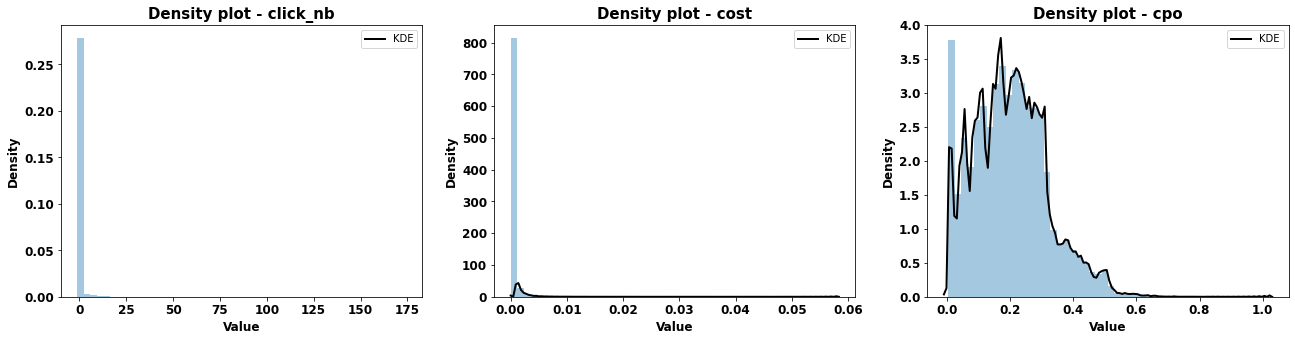

In [12]:
# plotting the values
plt.subplots(1,3, figsize=(22,5))


plt.subplot(1,3,1)
sns.distplot(df_eda['click_nb'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Value", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - click_nb", fontsize=15, fontweight='bold')

plt.subplot(1,3,2)
sns.distplot(df_eda['cost'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Value", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - cost", fontsize=15, fontweight='bold')

plt.subplot(1,3,3)
sns.distplot(df_eda['cpo'], kde_kws={"color": "k", "lw": 2, "label": "KDE"})
plt.xticks(fontsize=12, fontweight='bold')
plt.xlabel("Value", fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.ylabel("Density", fontsize=12, fontweight='bold')
plt.title("Density plot - cpo", fontsize=15, fontweight='bold')

plt.show()

### Bivariate and Multivariate analysis


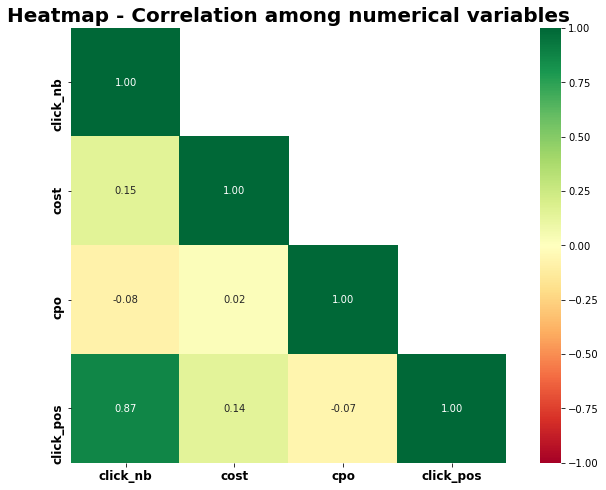

In [13]:
# correlation plot of numerical values
plt.figure(figsize=(12,8))
corr_var = df_eda[['click_nb','cost','cpo','click_pos']].corr()
sns.heatmap(corr_var, annot=True, square=True, fmt='.2f', cmap='RdYlGn', vmin=-1, mask=np.triu(corr_var, 1))
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title("Heatmap - Correlation among numerical variables", fontsize=20, fontweight='bold')
plt.show()

**Observations:**

* There is no or negligeble correlation among metrics.
* There are no interesting observations.

### Segregating categorical columns

In [14]:
catcolumns =['click_pos','attribution','conversion','click','cat1','cat2','cat3','cat4','cat5','cat6','cat7','cat8','cat9']
df_numerical = df_eda.loc[:, ~df_eda.columns.isin(catcolumns)]
df_categorical = df_eda[catcolumns]

In [15]:
df_numerical.head()

,uid,click_nb,cost,cpo
0,20073966,-1,0.000010,0.390794
1,24607497,-1,0.000010,0.059600
2,28474333,-1,0.000183,0.149706
3,7306395,7,0.000094,0.154785
4,25357769,-1,0.000032,0.037583


In [16]:
df_categorical.head()

,click_pos,attribution,conversion,click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9
0,-1,False,False,False,5824233,9312274,3490278,29196072,11409686,1973606,25162884,29196072,29196072
1,-1,False,False,False,30763035,9312274,14584482,29196072,11409686,1973606,22644417,9312274,21091111
2,-1,False,False,False,138937,9312274,10769841,29196072,5824237,138937,1795451,29196072,15351056
3,0,False,True,True,28928366,26597095,12435261,23549932,5824237,1973606,9180723,29841067,29196072
4,-1,False,False,False,138937,26597094,31616034,29196072,11409684,26597096,4480345,29196072,29196072


### Transforming attribution, conversion, click into 0/1 



In [17]:
df_categorical["attribution"] = df_categorical["attribution"].astype(int)
df_categorical["conversion"] = df_categorical["conversion"].astype(int)
df_categorical["click"] = df_categorical["click"].astype(int)

### Transforming cat1 into nominal using one hot encoding 


In [18]:
df_2=df_categorical['cat1'].value_counts().to_frame().reset_index()
df_categorical = pd.merge(df_categorical, df_2, how='left', left_on='cat1', right_on='index')
df_categorical.loc[(df_categorical['cat1_y']>=0) & (df_categorical['cat1_y']<=99), 'cat1_num'] = 1
df_categorical.loc[(df_categorical['cat1_y']>=100) & (df_categorical['cat1_y']<=999), 'cat1_num'] = 2
df_categorical.loc[(df_categorical['cat1_y']>=1000) & (df_categorical['cat1_y']<=9999), 'cat1_num'] = 3
df_categorical.loc[(df_categorical['cat1_y']>=10000) & (df_categorical['cat1_y']<=99999), 'cat1_num'] = 4
df_categorical.loc[(df_categorical['cat1_y']>=100000), 'cat1_num'] = 5
df_categorical.drop(['cat1_y','cat1_x','index'],axis=1, inplace=True)

### Transforming cat2 into ordinal 


In [19]:
df_2=df_categorical['cat2'].value_counts().to_frame().reset_index()
df_categorical = pd.merge(df_categorical, df_2, how='left', left_on='cat2', right_on='index')
df_categorical.loc[(df_categorical['cat2_y']>=0) & (df_categorical['cat2_y']<=99), 'cat2_num'] = 1
df_categorical.loc[(df_categorical['cat2_y']>=100) & (df_categorical['cat2_y']<=999), 'cat2_num'] = 2
df_categorical.loc[(df_categorical['cat2_y']>=1000) & (df_categorical['cat2_y']<=9999), 'cat2_num'] = 3
df_categorical.loc[(df_categorical['cat2_y']>=10000) & (df_categorical['cat2_y']<=99999), 'cat2_num'] = 4
df_categorical.loc[(df_categorical['cat2_y']>=100000), 'cat2_num'] = 5
df_categorical.drop(['cat2_y','cat2_x','index'],axis=1, inplace=True)

### Transforming cat3 into ordinal 



In [20]:
df_2=df_categorical['cat3'].value_counts().to_frame().reset_index()
df_categorical = pd.merge(df_categorical, df_2, how='left', left_on='cat3', right_on='index')
df_categorical.loc[(df_categorical['cat3_y']>=0) & (df_categorical['cat3_y']<=99), 'cat3_num'] = 1
df_categorical.loc[(df_categorical['cat3_y']>=100) & (df_categorical['cat3_y']<=999), 'cat3_num'] = 2
df_categorical.loc[(df_categorical['cat3_y']>=1000) & (df_categorical['cat3_y']<=9999), 'cat3_num'] = 3
df_categorical.loc[(df_categorical['cat3_y']>=10000) & (df_categorical['cat3_y']<=99999), 'cat3_num'] = 4
df_categorical.loc[(df_categorical['cat3_y']>=100000), 'cat3_num'] = 5
df_categorical.drop(['cat3_y','cat3_x','index'],axis=1, inplace=True)

### Transforming cat4 into ordinal 



In [21]:
df_2=df_categorical['cat4'].value_counts().to_frame().reset_index()
df_categorical = pd.merge(df_categorical, df_2, how='left', left_on='cat4', right_on='index')
df_categorical.loc[(df_categorical['cat4_y']>=0) & (df_categorical['cat4_y']<=99), 'cat4_num'] = 1
df_categorical.loc[(df_categorical['cat4_y']>=100) & (df_categorical['cat4_y']<=999), 'cat4_num'] = 2
df_categorical.loc[(df_categorical['cat4_y']>=1000) & (df_categorical['cat4_y']<=9999), 'cat4_num'] = 3
df_categorical.loc[(df_categorical['cat4_y']>=10000) & (df_categorical['cat4_y']<=99999), 'cat4_num'] = 4
df_categorical.loc[(df_categorical['cat4_y']>=100000), 'cat4_num'] = 5
df_categorical.drop(['cat4_y','cat4_x','index'],axis=1, inplace=True)

### Transforming cat5 into ordinal

In [22]:
df_2=df_categorical['cat5'].value_counts().to_frame().reset_index()
df_categorical = pd.merge(df_categorical, df_2, how='left', left_on='cat5', right_on='index')
df_categorical.loc[(df_categorical['cat5_y']>=0) & (df_categorical['cat5_y']<=99), 'cat5_num'] = 1
df_categorical.loc[(df_categorical['cat5_y']>=100) & (df_categorical['cat5_y']<=999), 'cat5_num'] = 2
df_categorical.loc[(df_categorical['cat5_y']>=1000) & (df_categorical['cat5_y']<=9999), 'cat5_num'] = 3
df_categorical.loc[(df_categorical['cat5_y']>=10000) & (df_categorical['cat5_y']<=99999), 'cat5_num'] = 4
df_categorical.loc[(df_categorical['cat5_y']>=100000), 'cat5_num'] = 5
df_categorical.drop(['cat5_y','cat5_x','index'],axis=1, inplace=True)


### Transforming cat6 into ordinal 

In [23]:
df_2=df_categorical['cat6'].value_counts().to_frame().reset_index()
df_categorical = pd.merge(df_categorical, df_2, how='left', left_on='cat6', right_on='index')
df_categorical.loc[(df_categorical['cat6_y']>=0) & (df_categorical['cat6_y']<=99), 'cat6_num'] = 1
df_categorical.loc[(df_categorical['cat6_y']>=100) & (df_categorical['cat6_y']<=999), 'cat6_num'] = 2
df_categorical.loc[(df_categorical['cat6_y']>=1000) & (df_categorical['cat6_y']<=9999), 'cat6_num'] = 3
df_categorical.loc[(df_categorical['cat6_y']>=10000) & (df_categorical['cat6_y']<=99999), 'cat6_num'] = 4
df_categorical.loc[(df_categorical['cat6_y']>=100000), 'cat6_num'] = 5
df_categorical.drop(['cat6_y','cat6_x','index'],axis=1, inplace=True)


### Transforming cat7 into ordinal 

In [24]:
df_2=df_categorical['cat7'].value_counts().to_frame().reset_index()
df_categorical = pd.merge(df_categorical, df_2, how='left', left_on='cat7', right_on='index')
df_categorical.loc[(df_categorical['cat7_y']>=0) & (df_categorical['cat7_y']<=99), 'cat7_num'] = 1
df_categorical.loc[(df_categorical['cat7_y']>=100) & (df_categorical['cat7_y']<=999), 'cat7_num'] = 2
df_categorical.loc[(df_categorical['cat7_y']>=1000) & (df_categorical['cat7_y']<=9999), 'cat7_num'] = 3
df_categorical.loc[(df_categorical['cat7_y']>=10000) & (df_categorical['cat7_y']<=99999), 'cat7_num'] = 4
df_categorical.loc[(df_categorical['cat7_y']>=100000), 'cat7_num'] = 5
df_categorical.drop(['cat7_y','cat7_x','index'],axis=1, inplace=True)


### Transforming cat8 into ordinal 

In [25]:
df_2=df_categorical['cat8'].value_counts().to_frame().reset_index()
df_categorical = pd.merge(df_categorical, df_2, how='left', left_on='cat8', right_on='index')
df_categorical.loc[(df_categorical['cat8_y']>=0) & (df_categorical['cat8_y']<=99), 'cat8_num'] = 1
df_categorical.loc[(df_categorical['cat8_y']>=100) & (df_categorical['cat8_y']<=999), 'cat8_num'] = 2
df_categorical.loc[(df_categorical['cat8_y']>=1000) & (df_categorical['cat8_y']<=9999), 'cat8_num'] = 3
df_categorical.loc[(df_categorical['cat8_y']>=10000) & (df_categorical['cat8_y']<=99999), 'cat8_num'] = 4
df_categorical.loc[(df_categorical['cat8_y']>=100000), 'cat8_num'] = 5
df_categorical.drop(['cat8_y','cat8_x','index'],axis=1, inplace=True)

### Transforming cat9 into ordinal 

In [26]:
df_2=df_categorical['cat9'].value_counts().to_frame().reset_index()
df_categorical = pd.merge(df_categorical, df_2, how='left', left_on='cat9', right_on='index')
df_categorical.loc[(df_categorical['cat9_y']>=0) & (df_categorical['cat9_y']<=99), 'cat9_num'] = 1
df_categorical.loc[(df_categorical['cat9_y']>=100) & (df_categorical['cat9_y']<=999), 'cat9_num'] = 2
df_categorical.loc[(df_categorical['cat9_y']>=1000) & (df_categorical['cat9_y']<=9999), 'cat9_num'] = 3
df_categorical.loc[(df_categorical['cat9_y']>=10000) & (df_categorical['cat9_y']<=99999), 'cat9_num'] = 4
df_categorical.loc[(df_categorical['cat9_y']>=100000), 'cat9_num'] = 5
df_categorical.drop(['cat9_y','cat9_x','index'],axis=1, inplace=True)


### Engineering extra columns
* Based on timestamp, I created a new column day, hour
* Created a column 'last_click' and 'first_click' to segregate last click and first click based on attribution
* Created a column 'delta' that denotes the time difference between the time of the ad and conversion

In [28]:
df_extra = pd.DataFrame() 


In [29]:
df_extra['day'] = (df.timestamp / 86400).astype(int)
df_extra['hour'] = (df.timestamp / 3600).astype(int)
df_extra['last_click'] = df.attribution * (df.click_pos == df.click_nb - 1).astype(int)
df_extra['first_click'] = df.attribution * (df.click_pos == 0).astype(int)
df_extra['delta'] = -1
df_extra.loc[df.conversion == 1, 'delta'] = df['conversion_timestamp'] - df['timestamp']

In [30]:
df_extra

,day,hour,last_click,first_click,delta
0,0,0,0,0,-1
1,0,0,0,0,-1
2,0,0,0,0,-1
3,0,0,0,0,1449190
4,0,0,0,0,-1
...,...,...,...,...,...
16468022,30,741,0,0,-1
16468023,30,741,0,0,-1
16468024,30,741,0,0,-1
16468025,30,741,0,0,-1


### Joined numerical, categorical and extra dataframes into one

In [31]:
X2 = df_numerical.join(df_categorical).join(df_extra)

In [32]:
X2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16468027 entries, 0 to 16468026
Data columns (total 22 columns):
 #   Column       Dtype  
---  ------       -----  
 0   uid          int64  
 1   click_nb     int64  
 2   cost         float64
 3   cpo          float64
 4   click_pos    int64  
 5   attribution  int64  
 6   conversion   int64  
 7   click        int64  
 8   cat1_num     float64
 9   cat2_num     float64
 10  cat3_num     float64
 11  cat4_num     float64
 12  cat5_num     float64
 13  cat6_num     float64
 14  cat7_num     float64
 15  cat8_num     float64
 16  cat9_num     float64
 17  day          int64  
 18  hour         int64  
 19  last_click   int64  
 20  first_click  int64  
 21  delta        int64  
dtypes: float64(11), int64(11)
memory usage: 2.7 GB


#### Converting these converted dataframes into a pickle to use for modeling


In [33]:
X2.to_pickle("./temp_df_2.pkl")

## PLEASE REFER TO THE MODELING FILE FOR MODELING AND RESULS SUMMARY